In [12]:
import pandas as pd
import numpy as np
import cv2
import heapq
import matplotlib.pyplot as plt
from characterextractor import characterExtractor

X = pd.read_csv("train_x.csv", header = None)

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
ce = characterExtractor(pd_data=X)


<2
<2
TRUE <2


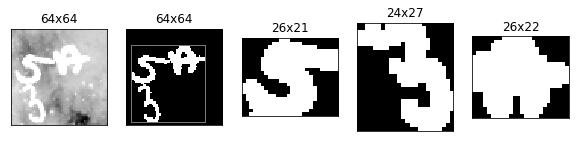

In [84]:
choice = 29035
ce.extractCharactersFromAndPlot(choice)